In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import networkx as nx
np.random.seed(42) 


In [2]:
class GenDisBM:
    def __init__(self, name, num_visible, num_output, num_hidden, connection):
        self.name = name
        self.num_visible = int(num_visible)
        self.num_output = int(num_output)
        self.num_hidden = int(num_hidden)
        self.num_input = int(self.num_visible - self.num_output)
        self.num_all = int(self.num_visible + self.num_hidden)
        self.num_all_states = 2**self.num_all

        self.connection = np.triu(np.sign(connection), 1)
        self.num_field_param = int(self.num_all)
        self.num_interaction_param = int(np.sum(self.connection))
        self.num_param = int(self.num_field_param + self.num_interaction_param)

        self.edge_map = np.array(np.where(self.connection == 1)).T
        self.edge_map_inverse = np.zeros_like(self.connection, dtype=int)
        for i, (x, y) in enumerate(self.edge_map):
            self.edge_map_inverse[x, y] = i

        self.max_field = 1
        self.max_interaction = 1

        self.cost_parameters = {'alpha': 0.5, 'beta': 1}

    def input_data(self, visible_data_states, visible_data_pmf=None):
        assert visible_data_states.shape[0] == self.num_visible, "Data dimensions mismatch"
        
        if visible_data_pmf is None:
            visible_data_pmf = np.ones(visible_data_states.shape[1]) / visible_data_states.shape[1]
        
        _, unique_indices = np.unique(visible_data_states[:self.num_input].T, axis=0, return_index=True)
        self.visible_data_states = visible_data_states[:, unique_indices]
        self.visible_data_pmf = visible_data_pmf[unique_indices]
        self.num_visible_data_states = len(self.visible_data_pmf)
        
        self.input_data_states = self.visible_data_states[:self.num_input]
        self.input_data_pmf = self.visible_data_pmf
        self.num_input_data_states = self.num_visible_data_states

        self.learning_parameters = {
            'learning_rate': 0.1,
            'weight_decay_rate': 0.0001,
            'momentum_rate': 0.0
        }

    def set_learning_parameters(self, learning_rate, weight_decay_rate, momentum_rate):
        self.learning_parameters.update({
            'learning_rate': learning_rate,
            'weight_decay_rate': weight_decay_rate,
            'momentum_rate': momentum_rate
        })

    def set_cost_parameters(self, alpha, beta):
        assert 0 <= alpha <= 1, "Alpha must be between 0 and 1"
        assert beta > 0, "Beta must be strictly positive"
        self.cost_parameters.update({'alpha': alpha, 'beta': beta})

    def update_graph_strength(self, h, j):
        assert len(h) == self.num_field_param, "Field parameter count mismatch"
        self.field_strength = h

        if j.shape == (self.num_all, self.num_all):
            self.interaction_strength = j
        elif len(j) == self.num_interaction_param:
            self.interaction_strength = np.zeros((self.num_all, self.num_all))
            for i, (x, y) in enumerate(self.edge_map):
                self.interaction_strength[x, y] = j[i]
        else:
            raise ValueError("Invalid shape for interaction strength")

    def optimize_bm(self, max_steps, start_point=None):
        if start_point is None or len(start_point) != self.num_param:
            start_point = np.random.rand(int(self.num_param))
        self.curr_point = start_point

        self._setup_optimization()

        bounds = [(-self.max_field, self.max_field)] * self.num_field_param + \
                 [(-self.max_interaction, self.max_interaction)] * self.num_interaction_param

        result = minimize(self._boltz_estimate, self.curr_point, method='L-BFGS-B',
                          jac=True, bounds=bounds, options={'maxiter': int(max_steps)})

        self.curr_point = result.x
        self.update_graph_strength(result.x[:self.num_field_param], result.x[self.num_field_param:])

    def _setup_optimization(self):
        self.states = np.array(list(map(int, np.binary_repr(i, width=self.num_all))) 
                               for i in range(self.num_all_states))
        self.energy_grad = np.column_stack((self.states, 
                                            np.prod(self.states[:, self.edge_map], axis=2)))

        self.input_start_index = np.array([int(''.join(map(str, state)) + '0' * (self.num_output + self.num_hidden), 2) 
                                           for state in self.input_data_states.T])
        self.visible_start_index = np.array([int(''.join(map(str, state)) + '0' * self.num_hidden, 2) 
                                             for state in self.visible_data_states.T])

    def _setup_optimization(self):
        self.states = np.array([list(map(int, np.binary_repr(i, width=self.num_all))) 
                                for i in range(self.num_all_states)])
        
        # Calculate the product of states for each edge
        edge_products = np.prod(self.states[:, self.edge_map.T], axis=2)
        
        self.energy_grad = np.column_stack((self.states, edge_products))

        self.input_start_index = np.array([int(''.join(map(str, state)) + '0' * (self.num_output + self.num_hidden), 2) 
                                        for state in self.input_data_states.T])
        self.visible_start_index = np.array([int(''.join(map(str, state)) + '0' * self.num_hidden, 2) 
                                            for state in self.visible_data_states.T])

    def _boltz_estimate(self, x):
        self.update_graph_strength(x[:self.num_field_param], x[self.num_field_param:])

        energy = np.dot(self.states, self.field_strength) + \
                np.sum(self.states[:, self.edge_map[:, 0]] * self.states[:, self.edge_map[:, 1]] * 
                        self.interaction_strength[self.edge_map[:, 0], self.edge_map[:, 1]], axis=1)

        z = np.sum(np.exp(-energy * self.cost_parameters['beta']))
        pr = np.exp(-energy * self.cost_parameters['beta']) / z

        pr_v = np.array([np.sum(pr[i:i+2**self.num_hidden]) for i in self.visible_start_index])
        pr_i = np.array([np.sum(pr[i:i+2**(self.num_output+self.num_hidden)]) for i in self.input_start_index])

        self.kl_div = np.sum(self.visible_data_pmf * np.log(self.visible_data_pmf / pr_v))
        self.n_cond_log_like = -np.sum(np.log(pr_v / pr_i))

        func = self.cost_parameters['alpha'] * self.kl_div + \
            (1 - self.cost_parameters['alpha']) / self.num_input_data_states * self.n_cond_log_like

        grad = np.zeros(self.num_param)
        grad[:self.num_field_param] = -self.cost_parameters['alpha'] * np.dot(pr, self.states)
        grad[self.num_field_param:] = -self.cost_parameters['alpha'] * np.dot(pr, self.states[:, self.edge_map[:, 0]] * self.states[:, self.edge_map[:, 1]])

        for k in range(self.num_visible_data_states):
            const = self.cost_parameters['alpha'] * self.visible_data_pmf[k] + \
                    (1 - self.cost_parameters['alpha']) / self.num_visible_data_states
            pr_slice = pr[self.visible_start_index[k]:self.visible_start_index[k]+2**self.num_hidden] / pr_v[k]
            grad[:self.num_field_param] += const * np.dot(pr_slice, self.states[self.visible_start_index[k]:self.visible_start_index[k]+2**self.num_hidden])
            grad[self.num_field_param:] += const * np.dot(pr_slice, self.states[self.visible_start_index[k]:self.visible_start_index[k]+2**self.num_hidden][:, self.edge_map[:, 0]] * 
                                                        self.states[self.visible_start_index[k]:self.visible_start_index[k]+2**self.num_hidden][:, self.edge_map[:, 1]])

        for k in range(self.num_input_data_states):
            const = (1 - self.cost_parameters['alpha']) / self.num_input_data_states
            pr_slice = pr[self.input_start_index[k]:self.input_start_index[k]+2**(self.num_output+self.num_hidden)] / pr_i[k]
            grad[:self.num_field_param] -= const * np.dot(pr_slice, self.states[self.input_start_index[k]:self.input_start_index[k]+2**(self.num_output+self.num_hidden)])
            grad[self.num_field_param:] -= const * np.dot(pr_slice, self.states[self.input_start_index[k]:self.input_start_index[k]+2**(self.num_output+self.num_hidden)][:, self.edge_map[:, 0]] * 
                                                        self.states[self.input_start_index[k]:self.input_start_index[k]+2**(self.num_output+self.num_hidden)][:, self.edge_map[:, 1]])

        return func, grad

    def plot_graph(self):
        G = nx.Graph()

        # Add nodes
        input_nodes = range(self.num_input)
        output_nodes = range(self.num_input, self.num_visible)
        hidden_nodes = range(self.num_visible, self.num_all)

        G.add_nodes_from(input_nodes, color='lightblue', node_type='input')
        G.add_nodes_from(output_nodes, color='lightgreen', node_type='output')
        G.add_nodes_from(hidden_nodes, color='lightpink', node_type='hidden')

        # Add edges
        for i, j in self.edge_map:
            weight = self.interaction_strength[i, j]
            G.add_edge(i, j, weight=weight)

        # Set up the plot
        fig, ax = plt.subplots(figsize=(12, 8))
        pos = nx.spring_layout(G)

        # Draw nodes
        nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, node_color='lightblue', node_size=500, label='Input', ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=output_nodes, node_color='lightgreen', node_size=500, label='Output', ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=hidden_nodes, node_color='lightpink', node_size=500, label='Hidden', ax=ax)

        # Draw edges
        edges = nx.draw_networkx_edges(G, pos, ax=ax)

        # Add labels
        nx.draw_networkx_labels(G, pos, ax=ax)

        # Add a colorbar for edge weights
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Edge Weights')

        # Set title and show the plot
        ax.set_title(f"Boltzmann Machine Graph: {self.name}")
        ax.legend()
        ax.axis('off')
        plt.tight_layout()
        plt.show()

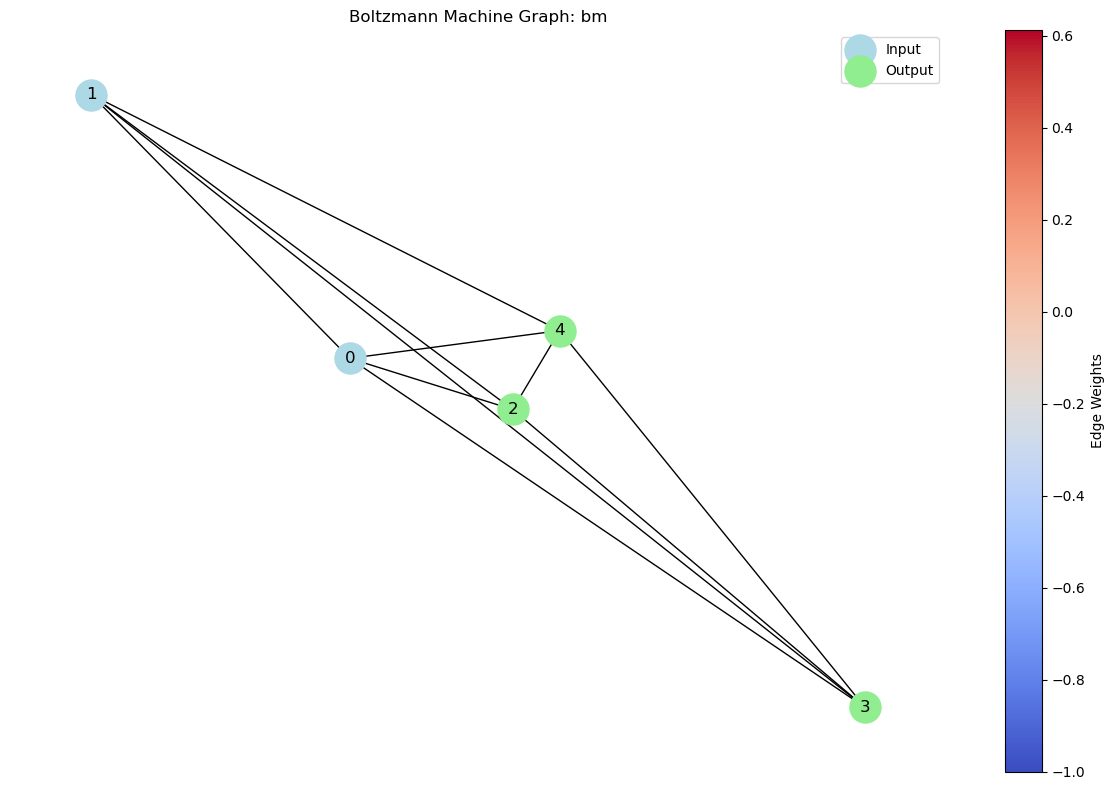

Optimization complete. Final KL Divergence: -0.14387929714028969
Final Negative Conditional Log-Likelihood: 0.016414952118883473


In [3]:

# Initialize BM
num_visible_node = 5
num_output_node = 3
num_hidden_node = 0

connection = np.triu(np.ones((num_visible_node + num_hidden_node, num_visible_node + num_hidden_node)))

# Initialize using constructor
bm = GenDisBM('bm', num_visible_node, num_output_node, num_hidden_node, connection)

# Input Data
data = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
])

# Insert data
bm.input_data(data)

# Define cost
beta = 10
alpha = 0.5
bm.set_cost_parameters(alpha, beta)

# Define constraints (optional)
# Uncomment and modify if needed
# a_cons = np.array([
#     [1] * bm.num_field_param + [0] * bm.num_interaction_param,
#     [0] * bm.num_field_param + [1] * bm.num_interaction_param
# ])
# b_cons = np.array([0, 0])
# bm.apply_constraints(a_cons, b_cons)

# Define Learning parameters for Momentum based method
learning_rate = 0.1
weight_decay_rate = 0.0001
momentum_rate = 0.00

bm.set_learning_parameters(learning_rate, weight_decay_rate, momentum_rate)

# Directly updating energy parameters (optional)
test_field_param = 2 * bm.max_field * (np.random.rand(bm.num_field_param) - 0.5)
test_interaction_param = 2 * bm.max_interaction * (np.random.rand(bm.num_interaction_param) - 0.5)
bm.update_graph_strength(test_field_param, test_interaction_param)

# Learning Step
# For first order momentum rate learning
learning_steps = 100
start_parameter = None

# Run optimization
bm.optimize_bm(learning_steps, start_parameter)

# For second order learning (using the same optimize_bm method)
learning_steps = 50
start_parameter = bm.curr_point

# Run optimization
bm.optimize_bm(learning_steps, start_parameter)

# Plotting and accessing parameters
bm.plot_graph()

# Accessing energies (if needed)
h = bm.field_strength
j = bm.interaction_strength

print("Optimization complete. Final KL Divergence:", bm.kl_div)
print("Final Negative Conditional Log-Likelihood:", bm.n_cond_log_like)
